In [1]:
%matplotlib inline
from CartPole import CartPole, remap_angle, _remap_angle, _loss, loss
import autograd.numpy as np
from matplotlib.pyplot import ion, draw, Rectangle, Line2D
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from sklearn import linear_model

# Week 1

In [2]:
initial_x = np.array([np.random.normal(), np.random.uniform(-10, 10), np.random.uniform(-np.pi,np.pi), np.random.uniform(-15,15)])
print(initial_x)

index_to_variable = {0 : 'cart_location', 1 : 'cart_velocity', 2 : 'pole_angle', 3 : 'pole_velocity'}

list_of_index_pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
x_range_for_index = {0 : np.linspace(-5,5,10), 1 : np.linspace(-10,10,10), 2 : np.linspace(-np.pi,np.pi,10), 3 : np.linspace(-15,15,10)}


[ 1.27538811  4.83331944 -3.02121303 10.59775726]


## Task 1.1

In [3]:
def move_cart(initial_x, steps=10, visual=False, display_plots=True, remap_angle=False):
    """
    
    Parameters
    ----------
    initial_x : list-like
        [cart_location, cart_velocity, pole_angle, pole_velocity]
    steps: int
        number of steps taken
    visual: bool
        whether to show image of cart state
    display_plots: bool
        
    remap_angle: bool
        whether to remap angle to between pi -pi
        
    Returns
    -------
    list 
        x_history of state at discrete intervals
    """
    assert steps != 4, "Sorry, I don't like 4 steps"
    
    cp = CartPole(visual=visual)
    cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity = initial_x
    
    for step in range(steps):
        if visual: cp.drawPlot()
        cp.performAction()
        if remap_angle: cp.remap_angle()
        try: 
            x_history = np.vstack((x_history, np.array([cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity])))
        except:
            x_history = np.array((initial_x, [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]))
        
    t = range(x_history.shape[0]) if steps > 1 else 1
    
    if display_plots and steps > 1:
        fig, axs = plt.subplots(2, 2, figsize=(12, 9))
        
        axs[0,0].plot(t, [x[0] for x in x_history])
        axs[0,0].set_ylabel('cart_location')
        axs[0,0].set_xlabel('time step')
        axs[0,1].plot(t, [x[1] for x in x_history])
        axs[0,1].set_ylabel('cart_velocity')
        axs[0,1].set_xlabel('time step')
        axs[1,0].plot(t, [x[2] for x in x_history])
        axs[1,0].set_ylabel('pole_angle')
        axs[1,0].set_xlabel('time step')
        axs[1,1].plot(t, [x[3] for x in x_history])
        axs[1,1].set_ylabel('pole_velocity')
        axs[1,1].set_xlabel('time step')
        fig.tight_layout()
    elif display_plots and steps == 1: print("You're trying to plot over {} steps, which is not plottable, pick a number greater than 1".format(steps))
        
    if len(x_history) != 4: return x_history[-1]
    else: return x_history

### Simple oscillation around stable equilibrium

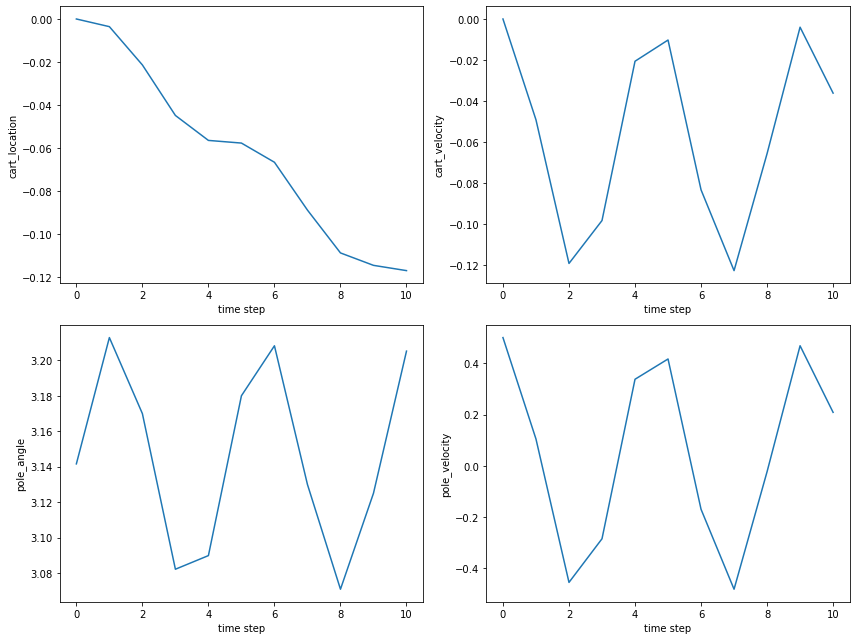

In [4]:
history = move_cart([0,0,np.pi,0.5], steps=10)

### Complete rotation of pendulum

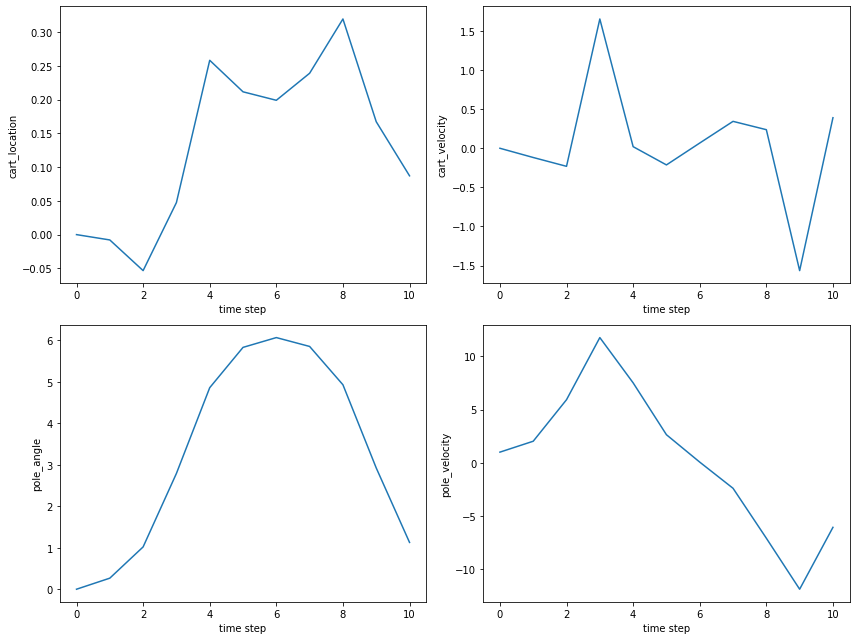

In [5]:
history = move_cart([0,0,0,1])

This is clearly a complete rotation, but the pole doesn't seem to ever hit 2pi because the pole angle is only sampled at discrete intervals therefore a value of exactly 2pi will never be recorded.

## Task 1.2

In [6]:
def plot_y(index, range_x):
    '''
    function for plotting y values when y is modelled 
    as X after one PerformAction step
    
    Parameters
    ----------
    index : int
        Which index of X (or variable) to scan over
    range_x : list-like
        Scan range
    '''
    
    x = initial_x.copy()
    y_results = []

    for i in range_x:
        x[index] = i
        y = move_cart(x, steps=1, display_plots=False)
        y_results.append(y)

    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs[0,0].plot(range_x, [y[0] for y in y_results])
    axs[0,0].set_ylabel('cart_location')
    axs[0,0].set_xlabel('{} initial value'.format(index_to_variable[index]))
    axs[0,1].plot(range_x, [y[1] for y in y_results])
    axs[0,1].set_ylabel('cart_velocity')
    axs[0,1].set_xlabel('{} initial value'.format(index_to_variable[index]))
    axs[1,0].plot(range_x, [y[2] for y in y_results])
    axs[1,0].set_ylabel('pole_angle')
    axs[1,0].set_xlabel('{} initial value'.format(index_to_variable[index]))
    axs[1,1].plot(range_x, [y[3] for y in y_results])
    axs[1,1].set_ylabel('pole_velocity')
    axs[1,1].set_xlabel('{} initial value'.format(index_to_variable[index]))
    fig.tight_layout()

#### Change cart location

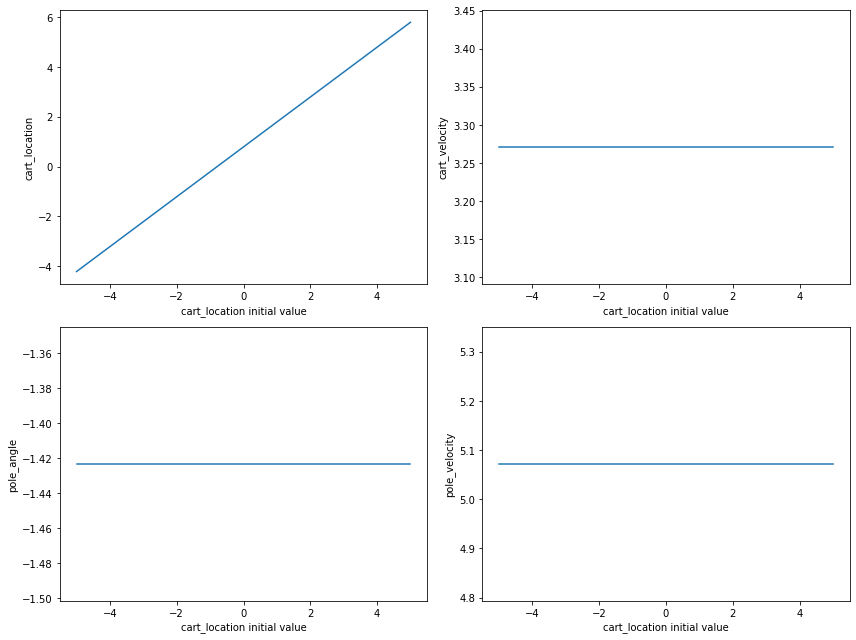

In [7]:
plot_y(0, np.linspace(-5,5,10))

#### Change cart velocity

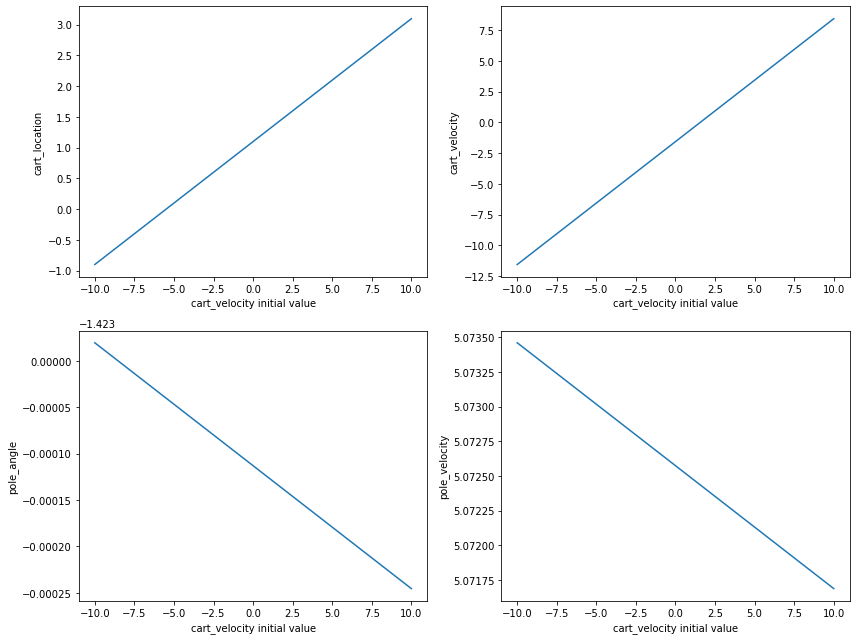

In [8]:
plot_y(1, np.linspace(-10,10,10))

#### Change pole angle

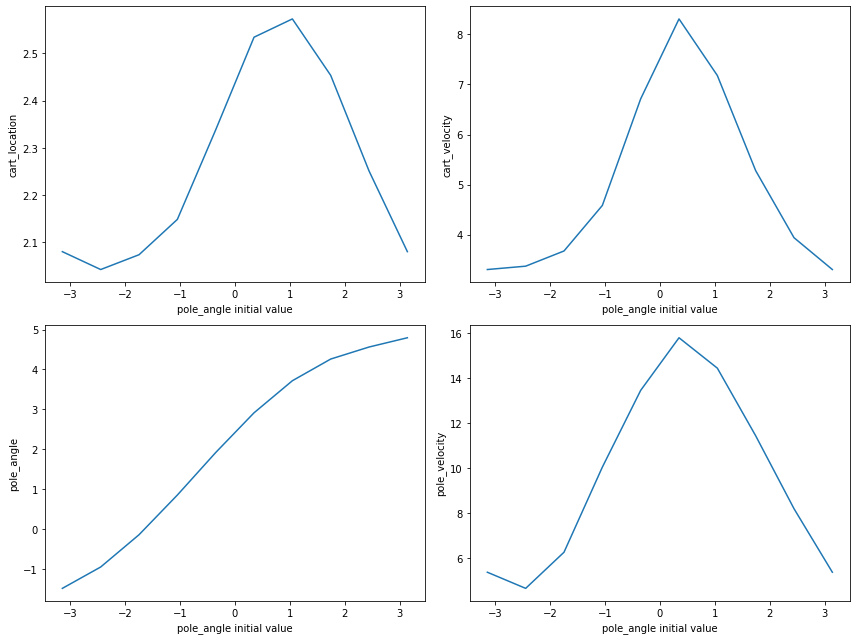

In [9]:
plot_y(2, np.linspace(-np.pi,np.pi,10))

#### Change pole velocity

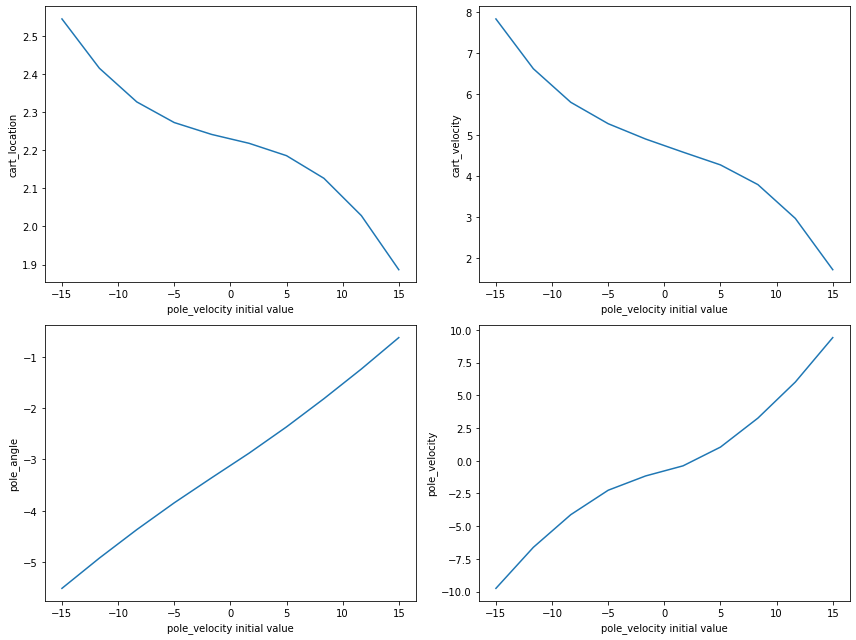

In [10]:
plot_y(3, np.linspace(-15,15,10))

The above plots are of Y modelled as X after one PerformAction

#### Modelling Y using Y = X(T) - X(0)

##### (i) scans of single variables

In [11]:
def plot_y_as_difference_in_x(index, range_x):
    '''
    function for plotting y values when y is modelled 
    as X(T) - X(0)
    
    Parameters
    ----------
    index : int
        Which index of X (or variable) to scan over
    range_x : list-like
        Scan range
    '''
    
    x = initial_x.copy()
    y_results = []

    for i in range_x:
        x[index] = i
        x_t = np.array(move_cart(x, steps=1, display_plots=False))
        try:
            x_t_results = np.vstack((x_t_results, x_t))
            x_0 = np.vstack((x_0, x))
        except:
            x_t_results = x_t
            x_0 = x.copy()
    
    
    y_results = x_t_results - x_0
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs[0,0].plot(range_x, [y[0] for y in y_results])
    axs[0,0].set_ylabel('Y_cart_location')
    axs[0,0].set_xlabel('{} initial value'.format(index_to_variable[index]))
    axs[0,1].plot(range_x, [y[1] for y in y_results])
    axs[0,1].set_ylabel('Y_cart_velocity')
    axs[0,1].set_xlabel('{} initial value'.format(index_to_variable[index]))
    axs[1,0].plot(range_x, [y[2] for y in y_results])
    axs[1,0].set_ylabel('Y_pole_angle')
    axs[1,0].set_xlabel('{} initial value'.format(index_to_variable[index]))
    axs[1,1].plot(range_x, [y[3] for y in y_results])
    axs[1,1].set_ylabel('Y_pole_velocity')
    axs[1,1].set_xlabel('{} initial value'.format(index_to_variable[index]))
    fig.suptitle('varying over {}'.format(index_to_variable[index]))
    fig.tight_layout()

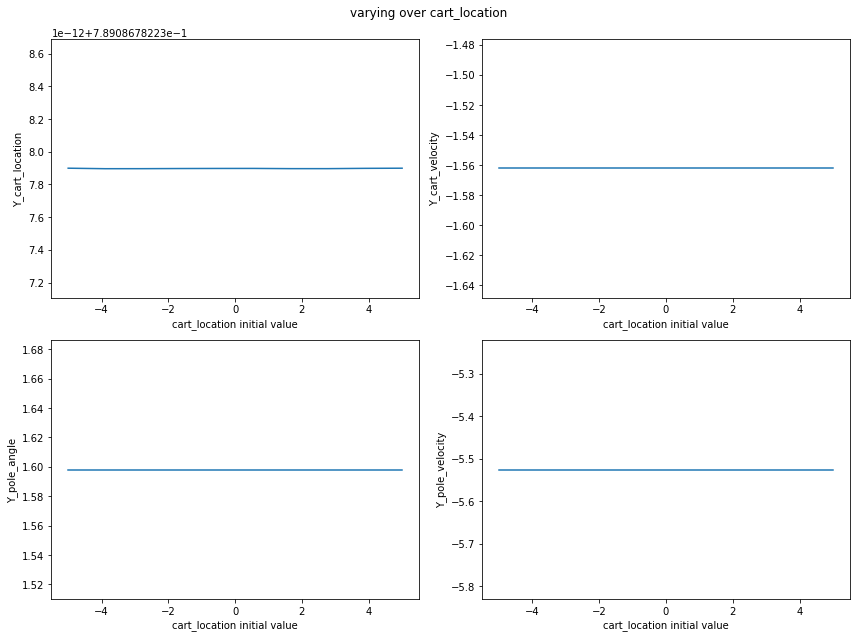

In [12]:
plot_y_as_difference_in_x(0, np.linspace(-5,5,10))

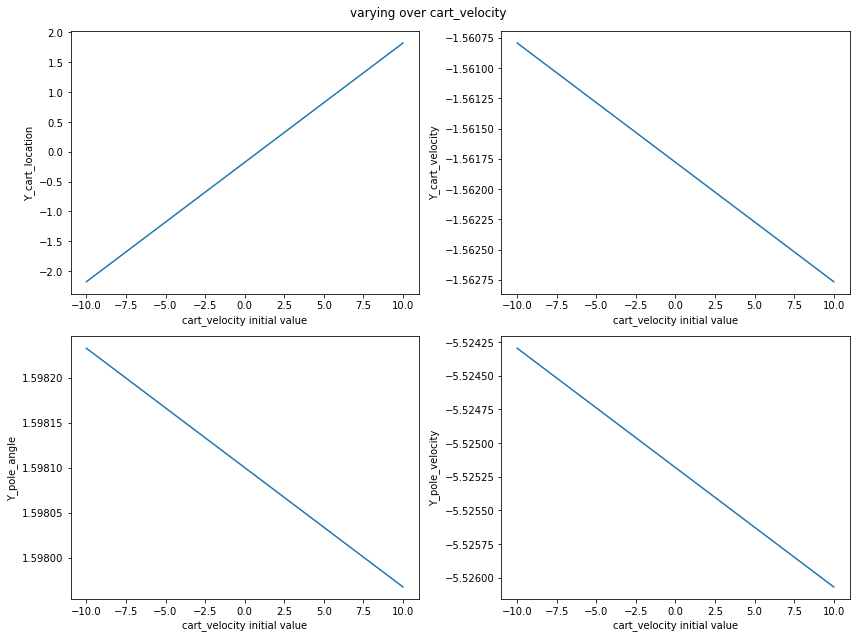

In [13]:
plot_y_as_difference_in_x(1, np.linspace(-10,10,10))

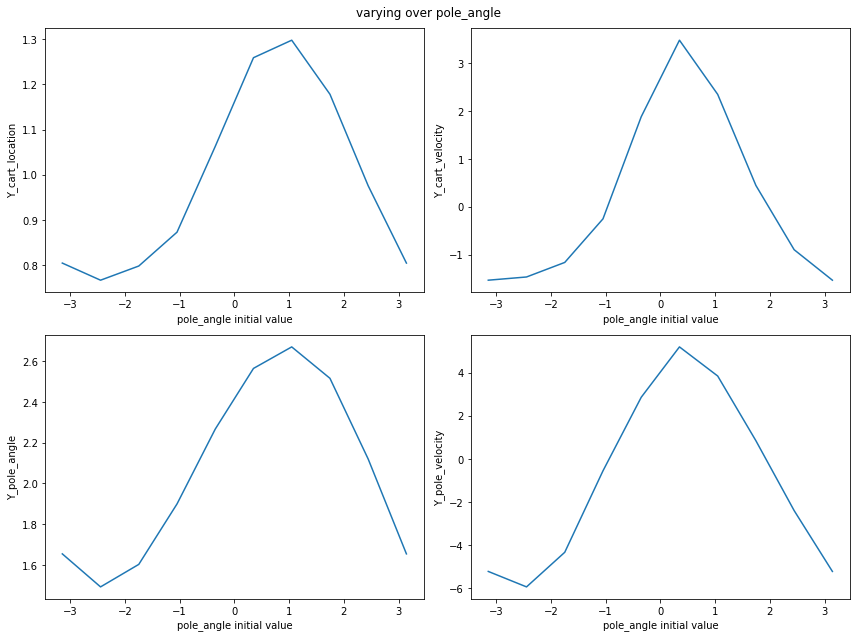

In [14]:
plot_y_as_difference_in_x(2, np.linspace(-np.pi,np.pi,10))

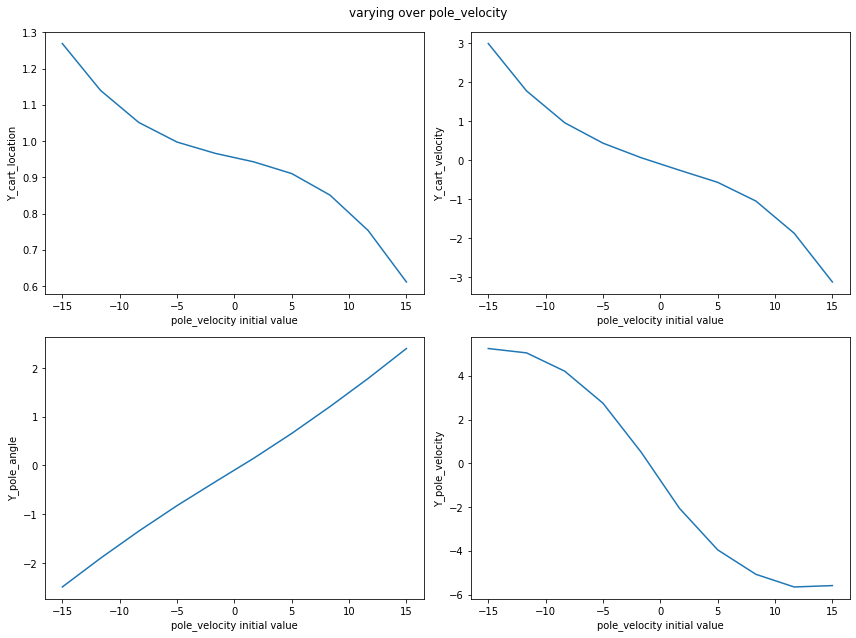

In [15]:
plot_y_as_difference_in_x(3, np.linspace(-15,15,10))

##### (ii) contour plots

In [16]:
def range_x_pair_finder(index_pair):
    range_x_pair = []
    for index in index_pair:
        range_x_pair.append(x_range_for_index[index])
    return range_x_pair

In [17]:
def plot_y_contour_as_difference_in_x(index_pair, range_x_pair):
    '''
    function for plotting y contours when y is modelled 
    as X(T) - X(0) and 2 variables are scanned across 
    
    Parameters
    ----------
    index_pair : list-like of int
        Which index pair of X (or variables) to scan over
    range_x_pair : list-like of list-like
        Scan range of both variables
    '''
   
    index_1, index_2 = index_pair
    range_1, range_2 = range_x_pair
    
    x_0_grid = np.zeros((len(range_1),len(range_2),4))
    x_t_grid = np.zeros((len(range_1),len(range_2),4))
    
    for i,value_1 in enumerate(range_1):
        for j, value_2 in enumerate(range_2):
            x = initial_x.copy()
            x[index_1] = value_1
            x[index_2] = value_2
            x_0_grid[i,j] = x
            x_t_grid[i,j] = np.array(move_cart(x, steps=1, display_plots=False))
                            
    y_grid = x_t_grid - x_0_grid
    y_grid = np.moveaxis(y_grid, -1, 0)   
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    
    axs[0,0].contourf(range_1, range_2, y_grid[0].T, vmin=y_grid.min(), vmax=y_grid.max())
    axs[0,0].set_title('cart_location')
    axs[0,0].set_xlabel('{} initial value'.format(index_to_variable[index_1]))
    axs[0,0].set_ylabel('{} initial value'.format(index_to_variable[index_2]))    
    axs[0,1].contourf(range_1, range_2, y_grid[1].T, vmin=y_grid.min(), vmax=y_grid.max())
    axs[0,1].set_title('cart_velocity')
    axs[0,1].set_xlabel('{} initial value'.format(index_to_variable[index_1]))
    axs[0,1].set_ylabel('{} initial value'.format(index_to_variable[index_2]))
    axs[1,0].contourf(range_1, range_2, y_grid[2].T, vmin=y_grid.min(), vmax=y_grid.max())
    axs[1,0].set_title('pole_angle')
    axs[1,0].set_xlabel('{} initial value'.format(index_to_variable[index_1]))
    axs[1,0].set_ylabel('{} initial value'.format(index_to_variable[index_2]))
    axs[1,1].contourf(range_1, range_2, y_grid[3].T, vmin=y_grid.min(), vmax=y_grid.max())
    axs[1,1].set_title('pole_velocity')
    axs[1,1].set_xlabel('{} initial value'.format(index_to_variable[index_1]))
    axs[1,1].set_ylabel('{} initial value'.format(index_to_variable[index_2]))
    fig.tight_layout()


In [18]:
# for index_pair in list_of_index_pairs:
#     print('_____________________Plots of {} vs {}_____________________'.format(index_to_variable[index_pair[0]],index_to_variable[index_pair[1]]))
#     plot_y_contour_as_difference_in_x(index_pair, range_x_pair_finder(index_pair))
#     plt.show()
#     plt.close()

From these plots, we can see that:
1. Initial values that lead affect Y linearly are:

    Cart location

    Cart velocity


2. Initial values that affect Y non-linearly are:

    Pole angle
    
    Pole velocity
    

Clearly the cart location does not affect any of these Y values. 


## Task 1.3

In [19]:
def generate_data(n, steps=1):
    for i in range(n):
        try:
            x_ = np.array([np.random.normal(), np.random.uniform(-10, 10), np.random.uniform(-np.pi,np.pi), np.random.uniform(-15,15)])
            y_ = np.array(move_cart(x_, steps=steps, display_plots=False)) - x_
            x = np.vstack((x, x_))
            y = np.vstack((y, y_))

        except:
            x = np.array([np.random.normal(), np.random.uniform(-10, 10), np.random.uniform(-np.pi,np.pi), np.random.uniform(-15,15)])
            y = np.array(move_cart(x, steps=steps, display_plots=False)) - x
            
    return x,y

In [20]:
def plot_predictions(predictions, y_test, x_test):
    assert predictions.shape == y_test.shape, 'mismatched shapes {} {}'.format(predictions.shape, y_test.shape)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs[0,0].scatter([x[0] for x in x_test], [y[0] for y in y_test])
    axs[0,0].scatter([x[0] for x in x_test], [pred[0] for pred in predictions])
    axs[0,0].set_ylabel('Y_cart_location')
    
    axs[0,1].scatter([x[1] for x in x_test], [y[1] for y in y_test], label='actual point')
    axs[0,1].scatter([x[1] for x in x_test], [pred[1] for pred in predictions], label='prediction')    
    axs[0,1].set_ylabel('Y_cart_velocity')
    
    axs[1,0].scatter([x[2] for x in x_test], [y[2] for y in y_test])
    axs[1,0].scatter([x[2] for x in x_test], [pred[2] for pred in predictions])
    axs[1,0].set_ylabel('Y_pole_angle')
    
    axs[1,1].scatter([x[3] for x in x_test], [y[3] for y in y_test])
    axs[1,1].scatter([x[3] for x in x_test], [pred[3] for pred in predictions])
    axs[1,1].set_ylabel('Y_pole_velocity')
    
    axs[0,1].legend()
    fig.tight_layout()
    

In [21]:
proportion_train = 0.9
n = 500
train_index = int(proportion_train*n)

x,y = generate_data(500)

x_train, y_train = x[:train_index], y[:train_index]
x_test, y_test = x[train_index:], y[train_index:]

x.shape,y[:,0].shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape

((500, 4), (500,), (450, 4), (450, 4), (50, 4), (50, 4))

In [22]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
reg.predict(x_test).shape

(50, 4)

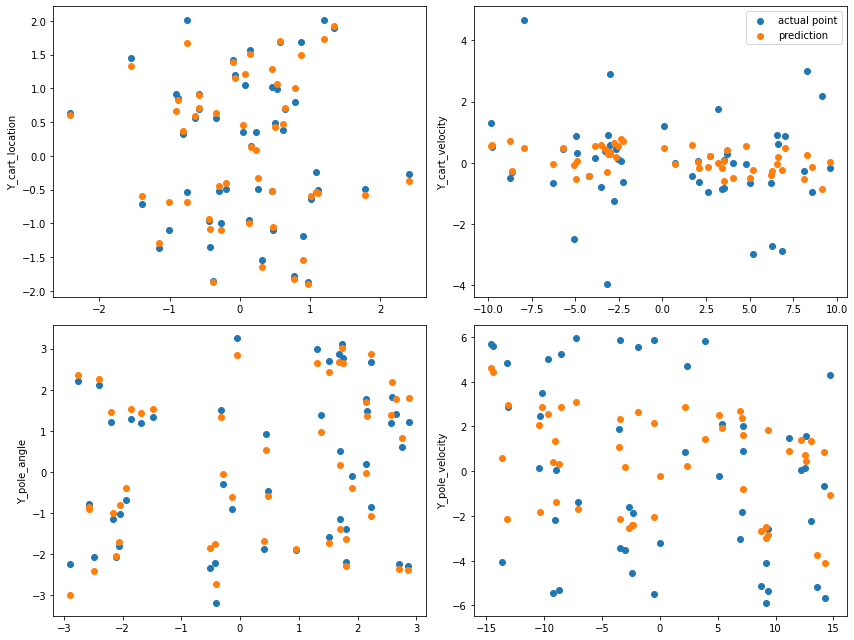

In [23]:
plot_predictions(reg.predict(x_test), y_test, x_test)

In [24]:
def plot_y_as_difference_in_x_with_regression(index, range_x, model=None):
    '''
    function for plotting y values when y is modelled 
    as X(T) - X(0)
    
    Parameters
    ----------
    index : int
        Which index of X (or variable) to scan over
    range_x : list-like
        Scan range
    '''
    
    x = initial_x.copy()
    y_results = []

    for i in range_x:
        x[index] = i
        x_t = np.array(move_cart(x, steps=1, display_plots=False))
        try:
            x_t_results = np.vstack((x_t_results, x_t))
            x_0 = np.vstack((x_0, x))
        except:
            x_t_results = x_t
            x_0 = x.copy()
    
    if model: predictions = model.predict(x_0)
    y_results = x_t_results - x_0
        
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs[0,0].plot(range_x, [y[0] for y in y_results], label='actual values')
    axs[0,0].plot(range_x, [pred[0] for pred in predictions], label='predicted values')
    axs[0,0].set_ylabel('Y_cart_location')
    axs[0,0].set_xlabel('{} initial value'.format(index_to_variable[index]))
    axs[0,1].plot(range_x, [y[1] for y in y_results], label='actual values')
    axs[0,1].plot(range_x, [pred[1] for pred in predictions], label='predicted values')
    axs[0,1].set_ylabel('Y_cart_velocity')
    axs[0,1].set_xlabel('{} initial value'.format(index_to_variable[index]))
    axs[1,0].plot(range_x, [y[2] for y in y_results], label='actual values')
    axs[1,0].plot(range_x, [pred[2] for pred in predictions], label='predicted values')
    axs[1,0].set_ylabel('Y_pole_angle')
    axs[1,0].set_xlabel('{} initial value'.format(index_to_variable[index]))
    axs[1,1].plot(range_x, [y[3] for y in y_results], label='actual values')
    axs[1,1].plot(range_x, [pred[3] for pred in predictions], label='predicted values')
    axs[1,1].set_ylabel('Y_pole_velocity')
    axs[1,1].set_xlabel('{} initial value'.format(index_to_variable[index]))
    fig.suptitle('varying over {}'.format(index_to_variable[index]))
    fig.tight_layout()

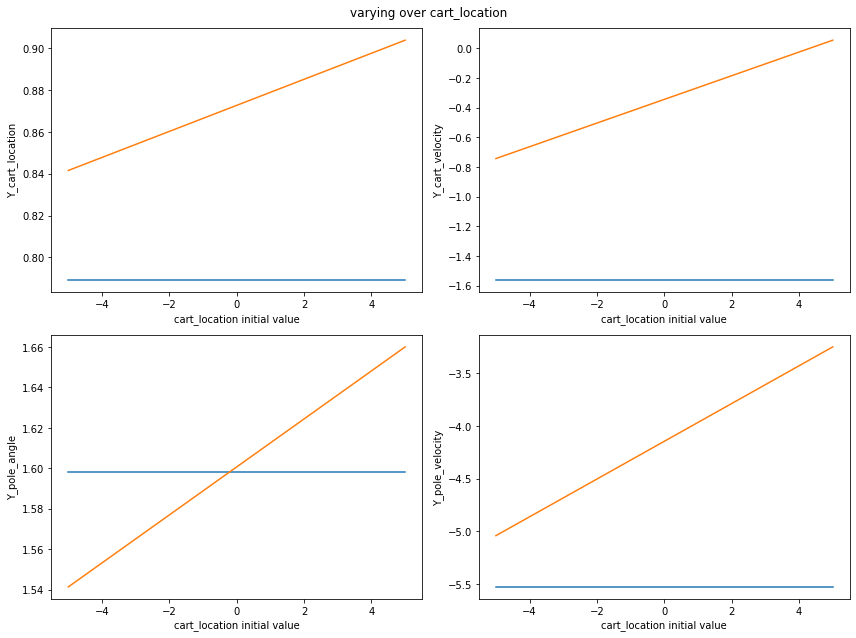

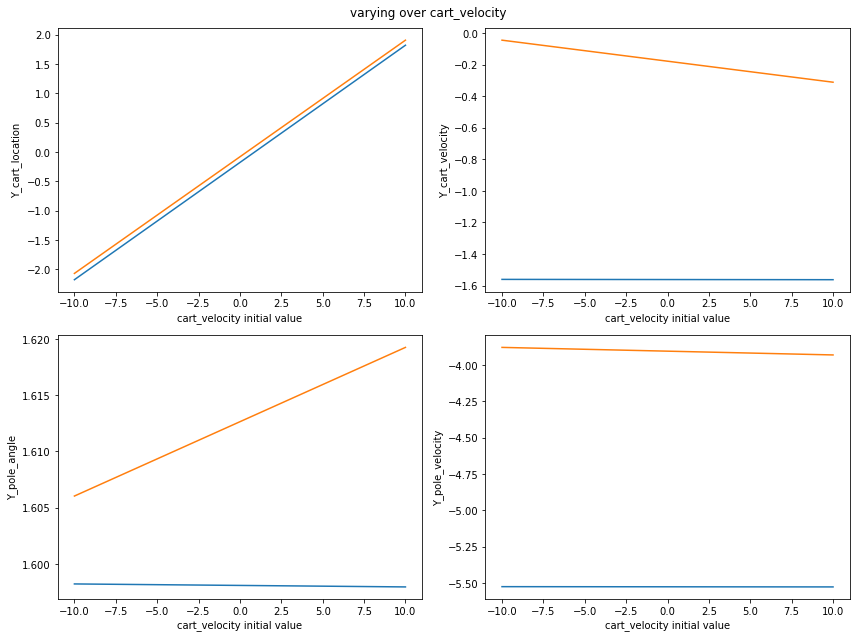

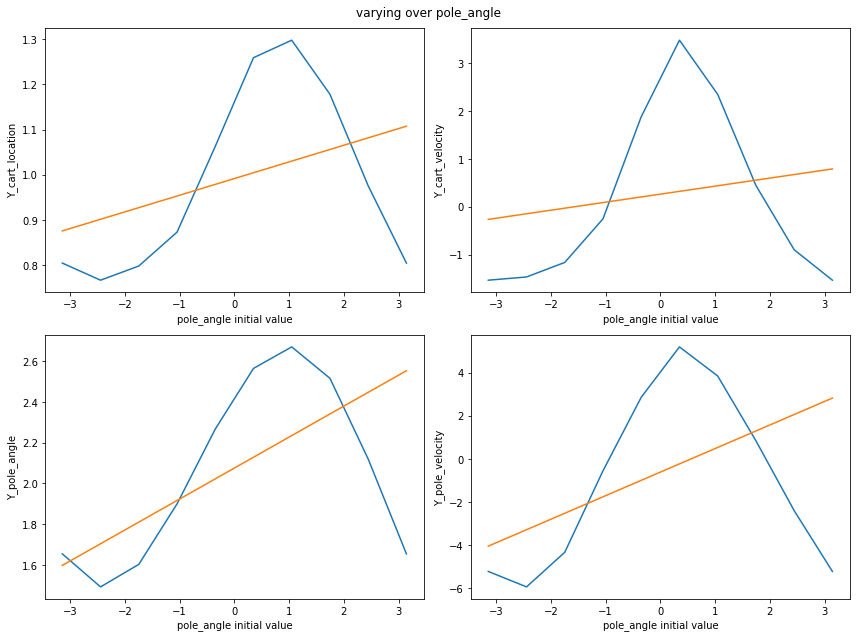

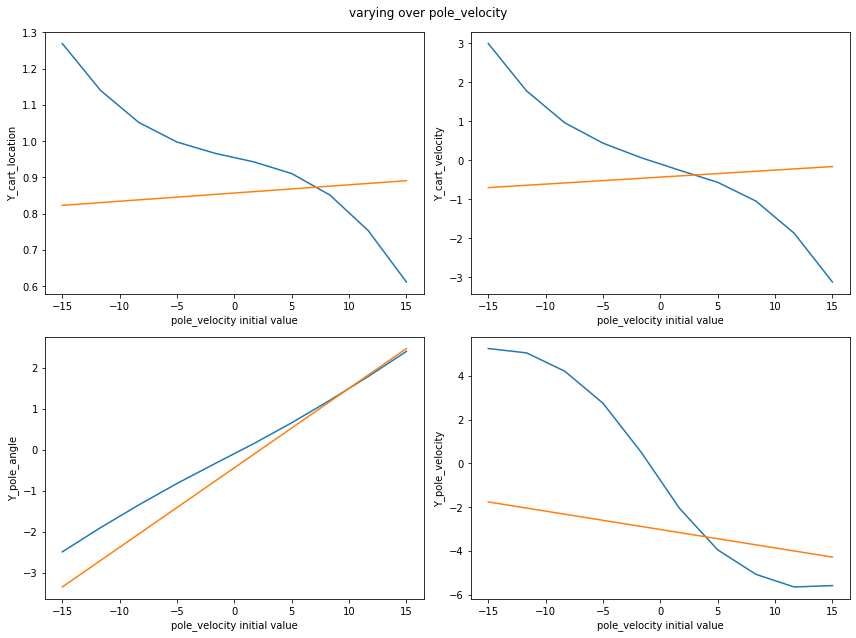

In [25]:
for i in range(4):
    plot_y_as_difference_in_x_with_regression(i, x_range_for_index[i], reg)